### Fetch data

#### Load dependencies

In [2]:
# path variables
import sys
sys.path.insert(0, '/Users/sarfrazahmed/Documents/projects/deposit-model/conf')
from config import SQLQuery

# core libraries
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# plotting libraries
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
from pandas_profiling import ProfileReport

# setting constants
pio.templates.default = 'plotly_dark'
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
color_map = {'high': '#00cc96', 'low': '#636efa'}

/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Fetching Data

In [3]:
querySno = SQLQuery('snowflake')
q = querySno

df_raw = q("""with 

TRANSACTIONS AS -- get all credit transactions
(
    select BUSINESS_ID,
           TRANSACTION_DATE,
           AMOUNT 
  from "PROD_DB"."DATA"."TRANSACTIONS" 
  where type='credit' and status='active'
  group by 1,2,3
),

BUSINESS_DETAIL as -- get all business accounts created between Jan 2021 and Feb 2022
(
  select *
  from "PROD_DB"."DATA"."BUSINESSES"
  where ACCOUNT_CREATE_DATE between '2021-01-01' and '2022-02-28'
),

ALLOY_PERSONS as -- get all the alloy persons data (max of application_versions_id in case of duplicates)
(
  select * from (
select * ,
       row_number() over (partition by APPLICATION_ID order by APPLICATION_VERSION_ID desc) as rank
from "PROD_DB"."DATA"."ALLOY_EVALUATIONS_PERSONS") 
where rank=1
),

APPLICATION_DETAIL as -- get all entries from applications table
(
  select *
  from "PROD_DB"."DATA"."APPLICATIONS"
),

BASE AS -- create base table with business and transactions
(
    select b.BUSINESS_ID,b.APPLICATION_ID,sum(t.amount) as total_credit_amount
    from BUSINESS_DETAIL b 
    inner join TRANSACTIONS t
    on b.BUSINESS_ID=t.BUSINESS_ID
    where DATEDIFF(day, ACCOUNT_CREATE_DATE, TRANSACTION_DATE) between 0 AND 60
    group by 1,2
)

    select * 
    from base
    left join APPLICATION_DETAIL B
    on base.APPLICATION_ID = B.APPLICATION_ID""")

df_raw.shape

(110642, 102)

#### Add target variable

In [4]:
df = df_raw.copy(deep=True)
df['deposit_class'] = np.where(df['total_credit_amount']<800, 'low', np.where(df['total_credit_amount']>1200, 'high', 'mid'))
df = df[df['deposit_class'] != 'mid']
print(df['deposit_class'].value_counts())
df.shape

low     53190
high    49719
Name: deposit_class, dtype: int64


(102909, 103)

#### Deposit Class Distribution

In [5]:
fig = px.histogram(df, 
                   x="deposit_class", 
                   color="deposit_class", 
                   text_auto=True, 
                   color_discrete_map=color_map)
fig.show()

#### Derived variables

In [6]:
# Application Completion Duration
df['application_completion_duration'] = (df['application_complete_datetime'] - df['application_start_datetime']).astype('timedelta64[m]')

# Email Domain
df['email_domain_variable'] = np.where(df['email_domain'].isin(['gmail.com', 'yahoo.com', 'outlook.com', 'icloud.com', 'hotmail.com']), df['email_domain'], 'others')

# Week Number
df['week'] = df['application_start_datetime'].dt.week

# Business Age
df['date_of_establishment_dt'] = pd.to_datetime(df['date_of_establishment'], format='%Y-%m', errors='coerce').dropna()
df['business_age'] = round((df['application_start_datetime'] - df['date_of_establishment_dt']) / np.timedelta64(1, 'Y'),2)
df['business_age'] = df['business_age'].fillna(0)

# Number of Employees
df["number_of_employees"] = pd.to_numeric(df["number_of_employees"])
df['number_of_employees_bin'] = df["number_of_employees"]
df['number_of_employees_bin'] = np.where((df['number_of_employees']>=5) & (df['number_of_employees']<=10), '5-10', 
                                np.where((df['number_of_employees']>10) & (df['number_of_employees']<=20), '11-20', 
                                np.where((df['number_of_employees']>20), '20+', df['number_of_employees_bin'])))

# Website Flag
df['website_flag'] = np.where(df['website'] != df['website'], 'Offline', 'Online')

/var/folders/gb/3vclgrsn0c93f13mbb7wggxc0000gn/T/ipykernel_7882/1308360415.py:8: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



#### List dependent and independent

In [7]:
dependent_variable = ['deposit_class']
independent_variables = ['business_type',
                         'business_address_state',
                         'email_domain_variable',
                         'application_completion_duration',
                         'application_channel',
                         'estimated_monthly_revenue', 
                         'incoming_ach_payments',
                         'check_deposit_amount',
                         'incoming_wire_transfer',
                         'outgoing_ach_and_checks',
                         'outgoing_wire_transfers',
                         'business_age',
                         'industry_category_name',
                         'number_of_employees_bin',
                         'website_flag',
                         'high_risk_industry',
                         'aml_risk_score',
                         'total_credit_amount']

#### Drop null rows

In [8]:
print(df.shape)
df.dropna(subset=independent_variables, inplace=True)
print(df.shape)

(102909, 110)
(102843, 110)


#### Encode categorical variables

In [9]:
for variable in list(df[independent_variables].select_dtypes(include=['object']).columns):
    df[variable]=df[variable].astype('category').cat.codes
df[independent_variables].head()

,business_type,business_address_state,email_domain_variable,application_completion_duration,application_channel,estimated_monthly_revenue,incoming_ach_payments,check_deposit_amount,incoming_wire_transfer,outgoing_ach_and_checks,outgoing_wire_transfers,business_age,industry_category_name,number_of_employees_bin,website_flag,high_risk_industry,aml_risk_score,total_credit_amount
0,1,39,3,22.0,4,4,2,2,0,2,0,2.30,13,0,1,0,174.0,3585.05
1,1,15,0,92.0,0,2,2,2,2,2,2,0.11,12,0,1,0,191.0,2273.43
2,1,9,0,60.0,4,2,5,0,2,0,2,1.59,16,0,1,0,140.0,50.00
3,3,36,0,16.0,4,4,4,5,0,4,0,0.00,6,0,1,0,245.0,25199.62
4,1,4,0,18.0,0,4,2,2,2,2,2,1.63,16,0,0,0,186.0,47212.47


#### Train test split

In [10]:
X = df[independent_variables]
y = df[dependent_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(20568, 18)
(82275, 18)
(20568, 1)
(82275, 1)


#### Decision Tree Fit

In [11]:
clf = tree.DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train.values, y_train.values)

DecisionTreeClassifier(max_depth=4, random_state=42)

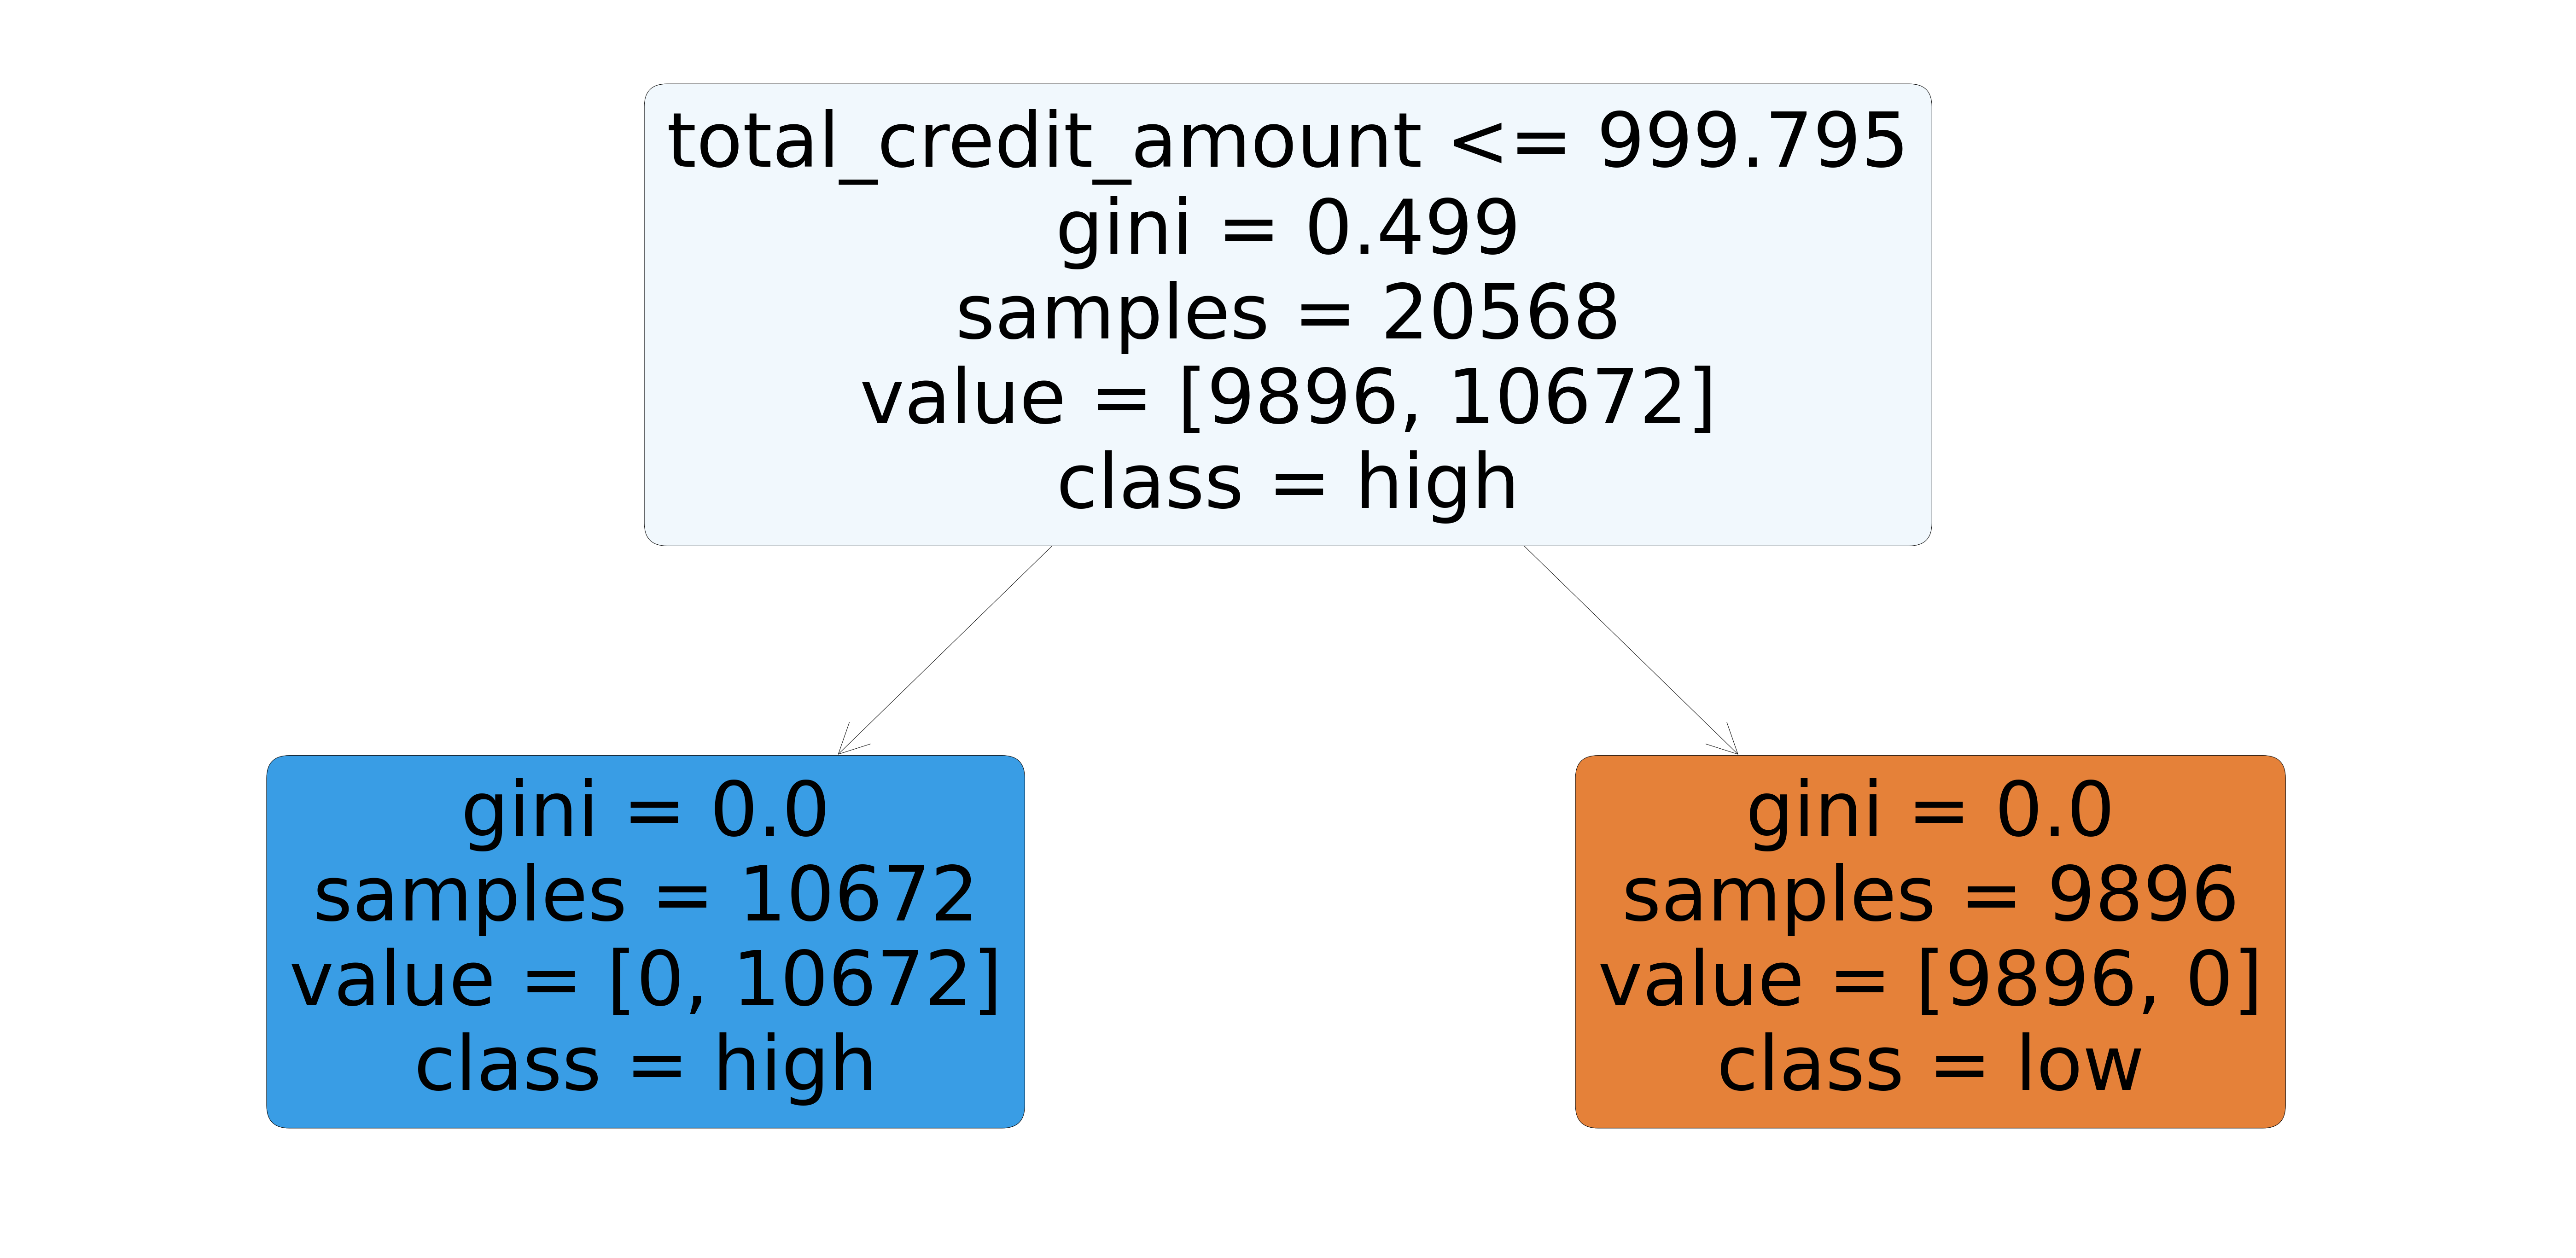

In [12]:
plt.figure(figsize=(100,50))
tree.plot_tree(clf,
               feature_names = X_train.columns, 
               class_names=y_train['deposit_class'].unique(),
               rounded=True,
               filled = True)
plt.show()

#### XGBoost Fit

In [13]:

model = XGBClassifier()
model.fit(X_train.drop(columns=['total_credit_amount']), y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/opt/homebrew/Caskroom/miniforge/bas

[17:54:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Train Report

In [14]:
y_pred = model.predict(X_train.drop(columns=['total_credit_amount']).values)

# Confusion Matrix
cmtx = pd.DataFrame(
    confusion_matrix(y_train, y_pred, labels=['high', 'low']), 
    index=['true:high', 'true:low'], 
    columns=['pred:high', 'pred:low']
)
print(cmtx, '\n')

# Accuracy Score
print('Accuracy Score:', accuracy_score(y_train, y_pred), '\n')

# Classification Report
print(classification_report(y_train, y_pred))

           pred:high  pred:low
true:high       7649      2247
true:low        1883      8789 

Accuracy Score: 0.7992026448852586 

              precision    recall  f1-score   support

        high       0.80      0.77      0.79      9896
         low       0.80      0.82      0.81     10672

    accuracy                           0.80     20568
   macro avg       0.80      0.80      0.80     20568
weighted avg       0.80      0.80      0.80     20568



#### Test Scores

In [15]:
y_pred = model.predict(X_test.drop(columns=['total_credit_amount']).values)

# Confusion Matrix
cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=['high', 'low']), 
    index=['true:high', 'true:low'], 
    columns=['pred:high', 'pred:low']
)
print(cmtx, '\n')

# Accuracy Score
print('Accuracy Score:', accuracy_score(y_test, y_pred), '\n')

# Classification Report
print(classification_report(y_test, y_pred))

           pred:high  pred:low
true:high      23290     16496
true:low       15225     27264 

Accuracy Score: 0.6144515344879976 

              precision    recall  f1-score   support

        high       0.60      0.59      0.59     39786
         low       0.62      0.64      0.63     42489

    accuracy                           0.61     82275
   macro avg       0.61      0.61      0.61     82275
weighted avg       0.61      0.61      0.61     82275



#### Median deposit binned by probabilities

In [16]:
def Extract(lst):
    return list(list(zip(*lst))[0])

res = model.predict_proba(X_test.drop(columns=['total_credit_amount'])).tolist()
class_proba = Extract(res)

X_test['class_probability'] = class_proba

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
X_test['binned'] = pd.cut(X_test['class_probability'], bins)

result_df = X_test.groupby('binned', as_index=False)['total_credit_amount'].median()
result_df['binned'] = result_df['binned'].astype('str')
fig = px.line(result_df, x='binned', y='total_credit_amount', markers=True)
fig.show()

/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

